In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:19<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define paths for train and test datasets
train_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN"
test_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob

In [6]:
x_data = []
y_data = []
for category in glob(train_path+"/*"):
    for file in tqdm(glob(category+"/*")):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split('/')[-1])
# Create a DataFrame from the image data (x_data) and labels (y_data) to organize the dataset

data = pd.DataFrame({'image':x_data,"label":y_data})

100%|██████████| 9999/9999 [00:04<00:00, 2195.96it/s]


In [7]:
# Display the shape of the DataFrame
data.shape

(22564, 2)

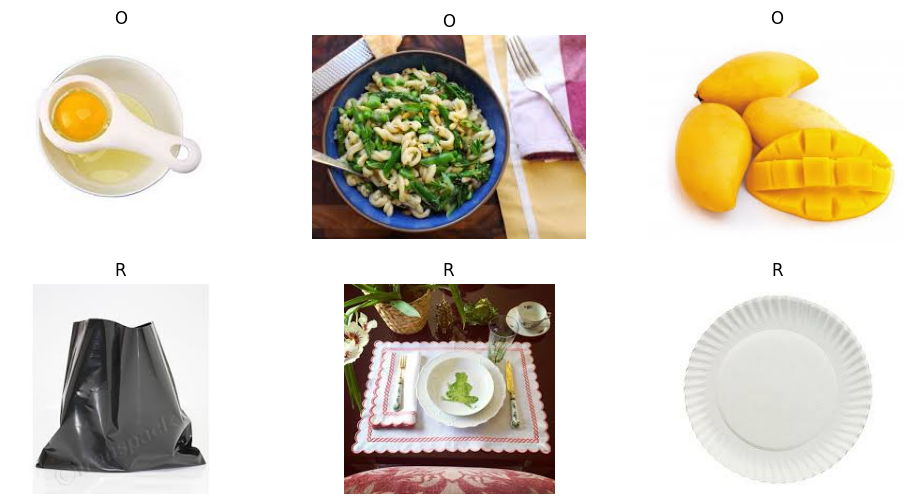

In [8]:
import matplotlib.pyplot as plt
import random
import os

# Visualize a few sample images from each class
def display_samples():
    classes = os.listdir(train_path)
    plt.figure(figsize=(12, 6))

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(train_path, class_name)
        image_files = os.listdir(class_folder)

        # Randomly pick 3 images from the class
        sample_images = random.sample(image_files, 3)

        for j, image_file in enumerate(sample_images):
            img_path = os.path.join(class_folder, image_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(classes), 3, i * 3 + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name}')

    plt.show()

display_samples()


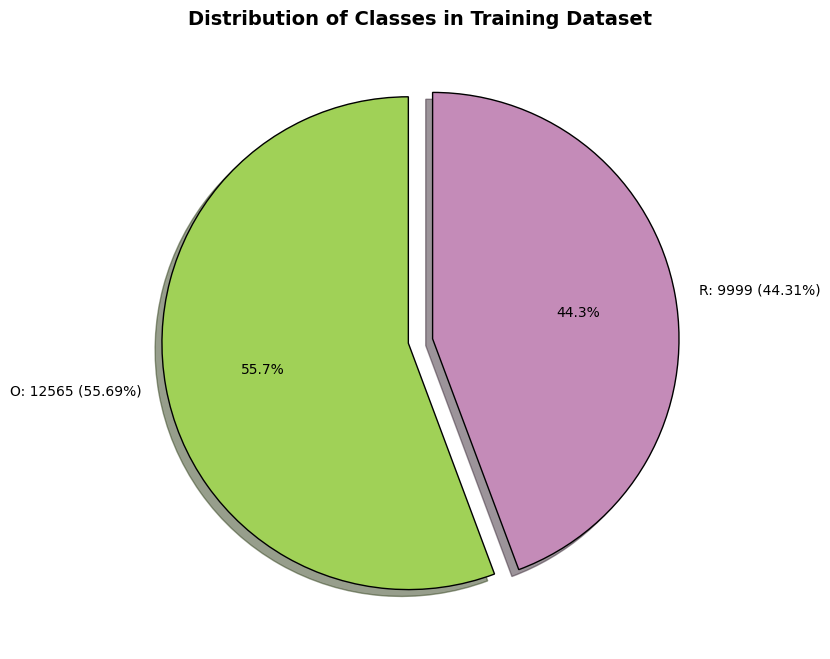

In [9]:
# Pie chart visualization with additional customizations

# Define custom colors for the pie chart
colors = ["#a0d157", "#c48bb8"]

# Create a figure with adjusted size for better readability
plt.figure(figsize=(8, 8))

# Pie chart with additional label formatting, count and percentage display
label_counts = data.label.value_counts()  # Get the count of each class

plt.pie(label_counts,
        labels=[f"{label}: {count} ({percent:.2f}%)" for label, count, percent in zip(label_counts.index, label_counts, 100 * label_counts / len(data))],
        autopct='%1.1f%%',  # Format the percentage display to one decimal place
        colors=colors,
        startangle=90,
        explode=[0.05, 0.05],  # Slightly "explode" the segments for emphasis
        shadow=True,  # Add shadow effect for better visualization
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'}  # Customize border for clarity
       )

# Title for the pie chart
plt.title("Distribution of Classes in Training Dataset", fontsize=14, fontweight='bold')

# Show the pie chart
plt.show()

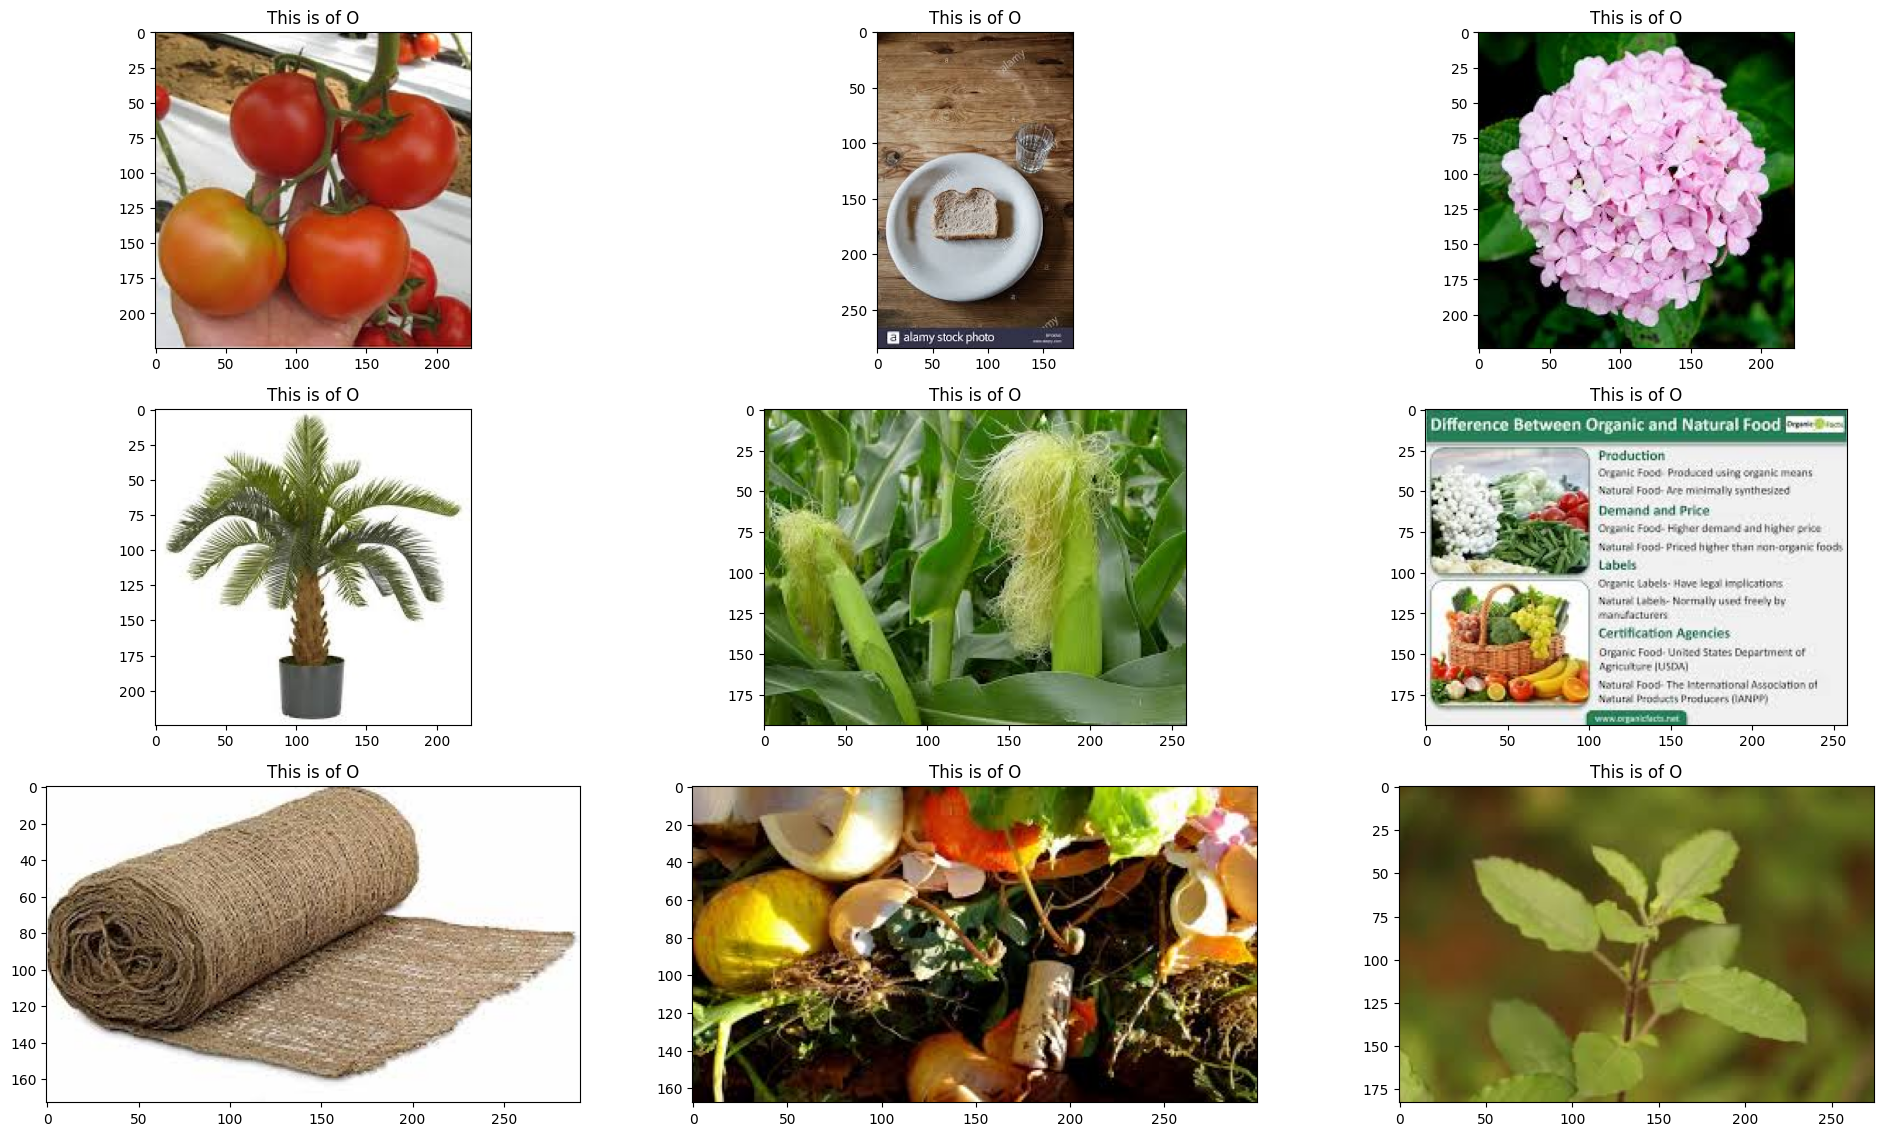

In [10]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

In [44]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [45]:
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights: ", class_weights_dict)

Class Weights:  {0: 0.8978909669717469, 1: 1.1283128312831283}


In [65]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing pixel values
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill missing pixels
)

In [66]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [67]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resize images to 224x224 (standard input for CNNs)
    batch_size=32,  # Batch size
    color_mode="rgb",  # RGB color images
    class_mode="binary",  # Binary classification (organic vs inorganic)
    shuffle=True
)

Found 22564 images belonging to 2 classes.


In [68]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",  # Binary classification
    shuffle=False
)

Found 2513 images belonging to 2 classes.


In [69]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D())

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# Flatten the output to feed into the Dense layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output layer (Binary classification: Organic or Inorganic)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
class_weights = {0: 1., 1: 2.}  # Modify these values based on the class distribution

# EarlyStopping to monitor validation loss and prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [72]:
hist = model.fit(
    train_generator,
    epochs=10,  # Adjust epochs depending on performance
    validation_data=test_generator,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stop]  # Early stopping to prevent overfitting
)

Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 285s 398ms/step - accuracy: 0.7503 - loss: 0.7809 - val_accuracy: 0.8599 - val_loss: 0.3657
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 271s 384ms/step - accuracy: 0.8130 - loss: 0.5802 - val_accuracy: 0.8770 - val_loss: 0.3330
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 290s 411ms/step - accuracy: 0.8207 - loss: 0.5557 - val_accuracy: 0.7589 - val_loss: 0.4668
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 271s 385ms/step - accuracy: 0.8321 - loss: 0.5301 - val_accuracy: 0.9013 - val_loss: 0.2605
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 270s 382ms/step - accuracy: 0.8361 - loss: 0.5085 - val_accuracy: 0.8878 - val_loss: 0.3017
Epoch 6/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 326s 388ms/step - accuracy: 0.8493 - loss: 0.4921 - val_accuracy: 0.8818 - val_loss: 0.2986
Epoch 7/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 268s 380ms/step - accuracy: 0.8536 - loss: 0.4746 - val_accuracy: 0.9029 - val_loss: 0.2748


In [73]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9200 - loss: 0.2238
Test accuracy: 0.9013131856918335
Test loss: 0.26049327850341797


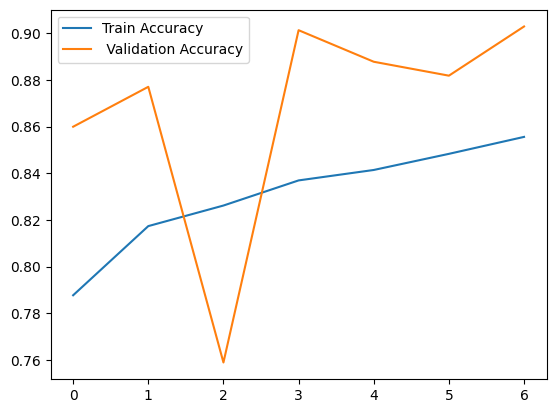

In [74]:

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label=' Validation Accuracy')
plt.legend()
plt.show()

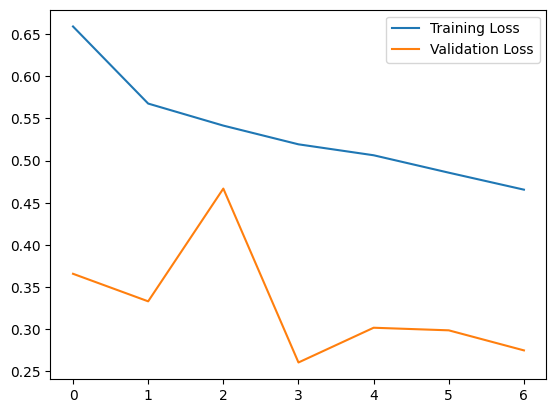

In [75]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [77]:
test_predictions = model.predict(test_generator)
predicted_classes = (test_predictions > 0.5).astype("int32")  # Convert probabilities to 0/1 labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


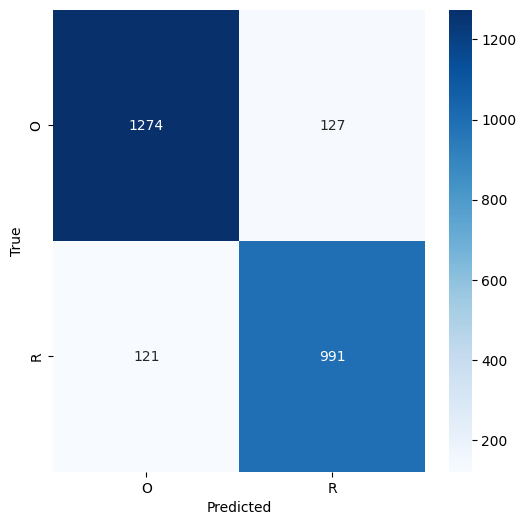

In [78]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

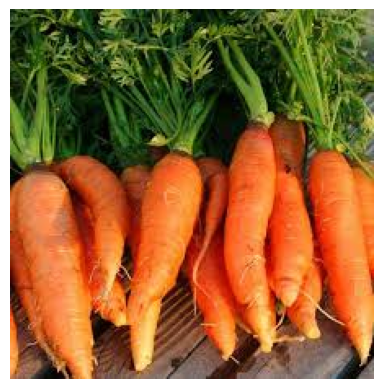

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This is Organic Waste.


In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_waste_type(img_path):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    img_resized = cv2.resize(img_rgb, (224, 224))  # Resize image to the required input shape
    img = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize image

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

    # Predict the class
    prediction = model.predict(img)
    if prediction > 0.5:
        print("This is Inorganic Waste.")
    else:
        print("This is Organic Waste.")

# Test prediction with an image
predict_waste_type('/content/O_12568.jpg')


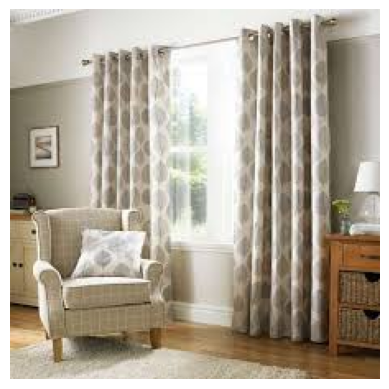

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This is Inorganic Waste.


In [109]:
predict_waste_type('/content/R_10047.jpg')

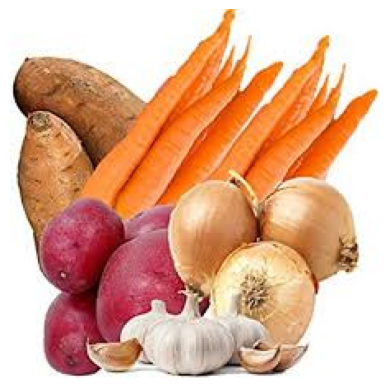

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
This is Organic Waste.


In [111]:
predict_waste_type('/content/O_12630.jpg')